# Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import seaborn as sns

# Read Data Files

In [2]:
# Companies
companies_df = pd.read_csv("AB_DSE_Screening_task/companies.txt", sep="\t", encoding = "ISO-8859-1")

# Investments
investment_df = pd.read_csv("AB_DSE_Screening_task/investment_rounds.csv", encoding="ISO-8859-1")

# Mapping
mapping_df = pd.read_csv("AB_DSE_Screening_task/mapping.csv", encoding="Latin-1")

# Initial Exploration and Cleaning

Keeping all datasets separate initially to clean the data and make it consistent.

The data must be in the same format when merging to ensure the primary keys are matched correctly. 

## companies.txt

In [3]:
companies_df.head()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/Organization/-The-One-Of-Them-Inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
3,/Organization/0-6-Com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007
4,/Organization/004-Technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010


#### Insights:
- There are mixture of cases being used. These need to be standardised for each column and carried through to the other datasets
- category_list can contain more than one category and is split by |. This could be dealt with by splitting into multiple columns or creating a list

In [4]:
# Find out some more about the dataset, e.g. number of rows, type of object, null values
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   permalink      66368 non-null  object
 1   name           66367 non-null  object
 2   homepage_url   61310 non-null  object
 3   category_list  63220 non-null  object
 4   status         66368 non-null  object
 5   country_code   59410 non-null  object
 6   state_code     57821 non-null  object
 7   region         58338 non-null  object
 8   city           58340 non-null  object
 9   founded_at     51147 non-null  object
dtypes: object(10)
memory usage: 5.1+ MB


#### Insights:
- There are a some null values - we can deal with these in data cleaning
- There are 66374 rows in the dataframe, which is helpful to know when we're looking at the significance of null values
- 'founded_at' is not in datetime format
- 'founded_at' appears to have the most null values, but this might be helpful for predicting the raised_amount_usd in the model. Perhaps later on we can create a new dataframe for this which can be used to create a separate model and cross validated

In [5]:
# Find out what the data looks like, i.e. duplicates, most common entry, number of unique values
companies_df.describe()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
count,66368,66367,61310,63220,66368,59410,57821,58338,58340,51147
unique,66368,66102,61191,27296,4,137,311,1092,5111,3978
top,/Organization/-Fame,Blink,http://www.askforoffer.com,Software,operating,USA,CA,SF Bay Area,San Francisco,01-01-2012
freq,1,4,5,3995,53034,37601,12900,8804,3526,2730


**Pre-Processing Question b)** How many unique companies are present in the companies file?

66368

#### Insights:
- Some company names are the same but they don't operate in the same category, region etc. so are still different companies
- Permalink seems to be the best way to merge datasets since it has no duplicate values
- Some websites have the same URL, these could have been acquired and lost over time
- Most companies are based in the USA
- Most companies are still operating, 80% to give an exact number
- We can't be confident in repeats until the entries have been standardised by case and type

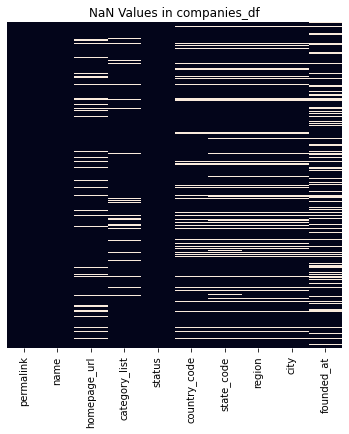

In [6]:
plt.figure(figsize=(6,6))
plt.title('NaN Values in companies_df')
sns.heatmap(companies_df.isnull(), cbar=False, yticklabels=False)
plt.show()

#### Insights:
- The missing values don't appear to be consistent in one row other than for country code, state code, region and city, so if we remove all null values we could actually be removing a lot of data. This can be confirmed later

In [7]:
# Find out the exact number of non-null values
companies_df.isna().sum()

permalink            0
name                 1
homepage_url      5058
category_list     3148
status               0
country_code      6958
state_code        8547
region            8030
city              8028
founded_at       15221
dtype: int64

### Cleaning the Data

We'd like:
- Consistency within columns i.e. lowercase or uppercase so we can correctly identify same entries or duplicates. We could see from the permalink that there is a variety of cases being used. These should be made constant so we can find the true number of unique values. 
- 'founded_at' to be in datetime format, as grouping by year and or month might be helpful later on in the analysis

#### 1. Change the Case

In [8]:
# Convert all entries to correct case
companies_df['permalink'] = companies_df['permalink'].str.lower()
companies_df['name'] = companies_df['name'].str.lower()
companies_df['homepage_url'] = companies_df['homepage_url'].str.lower()

companies_df['country_code'] = companies_df['country_code'].str.upper()
companies_df['state_code'] = companies_df['state_code'].str.upper()

companies_df['region'] = companies_df['region'].str.title()
companies_df['category_list'] = companies_df['category_list'].str.lower()
companies_df['status'] = companies_df['status'].str.title()
companies_df['city'] = companies_df['city'].str.title()

#### 2. Convert date to datetime format

Kept the original column as a cross reference for checking the date was converted correctly.

In [9]:
# Convert founded date to datetime format - keep as a separate column in case the date doesn't convert properly
companies_df['founded_date'] = pd.to_datetime(companies_df['founded_at'], errors='coerce')

In [10]:
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   permalink      66368 non-null  object        
 1   name           66367 non-null  object        
 2   homepage_url   61310 non-null  object        
 3   category_list  63220 non-null  object        
 4   status         66368 non-null  object        
 5   country_code   59410 non-null  object        
 6   state_code     57821 non-null  object        
 7   region         58338 non-null  object        
 8   city           58340 non-null  object        
 9   founded_at     51147 non-null  object        
 10  founded_date   51143 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(10)
memory usage: 5.6+ MB


#### 3. Check for duplicates

From the description of the dataset above, we could see that some company names were repeated. Let's check if these companies are actually duplicates or if they're just companies who have the same name. 

In [11]:
# Let's double check if there are any duplicate companies
repeat_names = companies_df['name'].value_counts()
repeat_names[repeat_names > 1]

roost        4
spire        4
shift        4
kiwi         4
blink        4
            ..
bento        2
horizon      2
handshake    2
remark       2
mobileway    2
Name: name, Length: 295, dtype: int64

In [12]:
# There are 295 duplicated company names
# The name appears up to 4 times for some companies so lets see that these companies are
roost = companies_df[companies_df['name'] == 'roost']
roost

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,founded_date
39726,/organization/notice-software,roost,http://roost.me/,apps|mobile|software,Operating,USA,NY,New York City,New York,01-01-2009,2009-01-01
48850,/organization/roost,roost,https://roost.com/,local based services|real estate|storage,Acquired,USA,CA,Sf Bay Area,San Francisco,01-05-2007,2007-01-05
48851,/organization/roost-6,roost,https://roost.com/,storage,Operating,USA,CA,Sf Bay Area,San Francisco,01-01-2014,2014-01-01
52548,/organization/smartroost,roost,http://getroost.com,home automation,Operating,USA,CA,Sf Bay Area,Sunnyvale,01-01-2014,2014-01-01


In [13]:
blink = companies_df[companies_df['name'] == 'blink']
blink

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,founded_date
7449,/organization/blink,blink,http://www.blink.la,content|journalism|location based services|med...,Operating,USA,NY,New York City,New York,01-01-2013,2013-01-01
7450,/organization/blink-4,blink,http://www.blinnnk.com/,software,Operating,JPN,18,Jpn - Other,China,01-01-2014,2014-01-01
7451,/organization/blink-7,blink,http://blinkforhome.com,electronics,Operating,USA,MA,Boston,Boston,NaN,NaT
7452,/organization/blink-9,blink,http://www.flyblink.com/,location based services|service providers,Operating,GBR,N7,Camberley,Camberley,NaN,NaT


This was tried for other companies, and it resulted than the companies appeared to be different as they're still operating (assuming the data is still up to date), are in different regions, different categories and have no other common values.

#### 4. Format the category_list column

Another observation is that there are multiple categories in the list section. These can be split by their spearator | into a list. 

*This ended up being hashed out as it was more difficult to save the dataframe as a csv and import it as a list*

In [14]:
# companies_df['category_list'] = companies_df['category_list'].str.split('|')

#### 5. Re-check the data for further cleaning

In [15]:
companies_df['founded_date'].describe(datetime_is_numeric=True)

count                            51143
mean     2007-11-18 00:59:44.865964032
min                1749-01-01 00:00:00
25%                2006-01-01 00:00:00
50%                2010-04-22 00:00:00
75%                2013-01-01 00:00:00
max                2105-02-17 00:00:00
Name: founded_date, dtype: object

In [16]:
companies_df.describe(include=['O'])

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
count,66368,66367,61310,63220,66368,59410,57821,58338,58340,51147
unique,66368,66037,61187,27296,4,137,311,1092,5111,3978
top,/organization/-fame,roost,http://www.askforoffer.com,software,Operating,USA,CA,Sf Bay Area,San Francisco,01-01-2012
freq,1,4,5,3995,53034,37601,12900,8804,3526,2730


#### 6. Removing Anomolies

The date here is clearly wrong. Let's plot all the dates to find out which are outliers or not.

The first date is 1749 which seems extremely early and the latest date is 2105 which hasn't happened yet. Let's visualise these outliers.

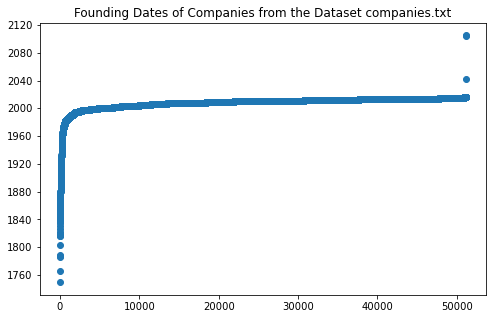

In [17]:
# Sort by date founded
founded_date = companies_df.sort_values(by='founded_date').reset_index()

# Plot date in increasing order
plt.figure(figsize=(8,5))
plt.scatter(founded_date.index, founded_date['founded_date'])
plt.title('Founding Dates of Companies from the Dataset companies.txt')
plt.show()

We can see some obvious insights from this data:
1. There are some false data where the year founded is beyond 2022. These will be removed
2. The majority of companies founded dates are beyond the year 2000. This is likely to be more relevant to the model, so later we might remove any data prior to this. 

Double check the data is wrong rather than the conversion being wrong (i.e. compare founded at to founded date).

In [18]:
companies_df[companies_df['founded_date'] > '2022-05-27']

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,founded_date
16681,/organization/dugoutfc-ltd,dugoutfc ltd,http://www.dugoutfc.com,fantasy sports,Operating,NaN,NaN,NaN,NaN,17-02-2105,2105-02-17
32736,/organization/livamp-2,livamp,http://www.livamp.com,entertainment|music|video,Closed,NaN,NaN,NaN,NaN,21-09-2041,2041-09-21
53396,/organization/soply,soply,https://soply.com/,creative industries|digital media|marketplaces,Operating,GBR,H9,London,London,01-01-2104,2104-01-01


As there are only three anomolies they were removed, as there could be mistakes in the rest of the row if there was a mistake in entering the year founded. 

In [19]:
# Remove any dates beyond today (i.e. the 3 shown above)
companies_df = companies_df[companies_df['founded_date'] <= '2022-05-27']

# Drop the original date column
companies_df = companies_df.drop(columns=['founded_at'])

## investment_rounds.csv

In [20]:
investment_df.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0
3,/ORGANIZATION/-THE-ONE-OF-THEM-INC-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0


Similar insights to the companies file:
- Mix of cases
- Some NaN values obvious already (check below)
- Looks like funding_round_permalink could be the most unique column here

In [21]:
investment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114949 entries, 0 to 114948
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   company_permalink        114949 non-null  object 
 1   funding_round_permalink  114949 non-null  object 
 2   funding_round_type       114949 non-null  object 
 3   funding_round_code       31140 non-null   object 
 4   funded_at                114949 non-null  object 
 5   raised_amount_usd        94959 non-null   float64
dtypes: float64(1), object(5)
memory usage: 5.3+ MB


Biggest observation here is the number of null values that exist for the funding_round_code. funded_at is also an object rather than in datetime format.

In [22]:
investment_df.describe()

,raised_amount_usd
count,9.495900e+04
mean,1.042687e+07
std,1.148212e+08
min,0.000000e+00
25%,3.225000e+05
50%,1.680511e+06
75%,7.000000e+06
max,2.127194e+10


The mean is actually quite far off the median, and is even higher than the upper quartile. This suggests there are probably some outliers. The standard deviation is also really high. 

The highest investment is 20,000,000,000 (20 billion) which is extremely high. This is very likely to be a typo but will be checked later when the data is filtered from the merged dataframe. 

In [23]:
investment_df.describe(include=['O'])

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at
count,114949,114949,114949,31140,114949
unique,90247,114949,14,8,5033
top,/ORGANIZATION/SOLARFLARE,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,A,01-01-2014
freq,10,1,55494,14747,779


**Pre-Processing Question b)** How many unique companies are present in investment_rounds?

90247

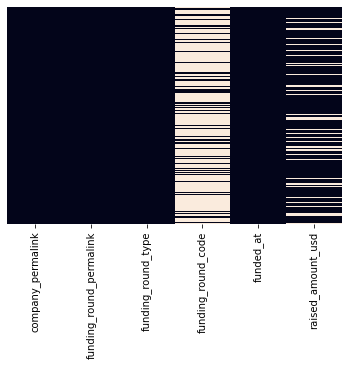

In [24]:
sns.heatmap(investment_df.isnull(), cbar=False, yticklabels=False)
plt.show()

In [25]:
investment_df.isna().sum()

company_permalink              0
funding_round_permalink        0
funding_round_type             0
funding_round_code         83809
funded_at                      0
raised_amount_usd          19990
dtype: int64

Insights:
- There are 66370 unique companies in the investment_round file
- some companies appear up to 19 times, meaning they have been through up to 19 investment rounds 
- Some of these companies likely went through multiple investment rounds as there are many more funding_round_permalink entries, each of which is unique
- The most common funding round code is A (series A assuming) which is the first round, which is expected as all companies would make it to this but not many would make it much further
- Venture is the most common funding round type
- A lot of funding round codes are missing as well as raised amount in USD

### Clean the Data

#### 1. Change date to datetime format

In [26]:
investment_df['funded_at'] = pd.to_datetime(investment_df['funded_at'], errors='coerce')

#### 2. Check the range of dates for outliers

In [27]:
investment_df['funded_at'].describe(datetime_is_numeric=True)

count                           114949
mean     2011-11-06 11:47:14.457019904
min                1960-01-01 00:00:00
25%                2010-03-02 00:00:00
50%                2012-11-01 00:00:00
75%                2014-04-24 00:00:00
max                2015-12-11 00:00:00
Name: funded_at, dtype: object

- The mean and median are quite close to each other
- The 75th percentile is very close to the maximum value
- The earliest date of investment is 1960 which seems very early

#### 3. Change the case of entries

In [28]:
# Convert all entries to correct case
investment_df['company_permalink'] = investment_df['company_permalink'].str.lower()
investment_df['funding_round_permalink'] = investment_df['funding_round_permalink'].str.lower()

investment_df['funding_round_code'] = investment_df['funding_round_code'].str.upper()

investment_df['funding_round_type'] = investment_df['funding_round_type'].str.title()

# Merging Datasets

Use an Inner join, as we don't want investment round data without the information on the company, but equally we don't want company information without knowing anything about their investment rounds. This won't help us when we're trying to build the model later on. 

In [29]:
# Merge companies_df with investments_df
merged_df = pd.merge(companies_df, investment_df, how='inner', left_on='permalink', right_on='company_permalink')
merged_df = merged_df.drop(['company_permalink'], axis=1)
merged_df.head()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_date,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-qounter,:qounter,http://www.qounter.com,application platforms|real time|social network...,Operating,USA,DE,De - Other,Delaware City,2014-04-09,/funding-round/22dacff496eb7acb2b901dec1dfe5633,Venture,A,2014-10-14,NaN
1,/organization/-qounter,:qounter,http://www.qounter.com,application platforms|real time|social network...,Operating,USA,DE,De - Other,Delaware City,2014-04-09,/funding-round/b44fbb94153f6cdef13083530bb48030,Seed,NaN,2014-01-03,700000.0
2,/organization/0-6-com,0-6.com,http://www.0-6.com,curated web,Operating,CHN,22,Beijing,Beijing,2007-01-01,/funding-round/5727accaeaa57461bd22a9bdd945382d,Venture,A,2008-03-19,2000000.0
3,/organization/004-technologies,004 technologies,http://004gmbh.de/en/004-interact,software,Operating,USA,IL,"Springfield, Illinois",Champaign,2010-01-01,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,Venture,NaN,2014-07-24,NaN
4,/organization/0ndine-biomedical-inc,ondine biomedical inc.,http://ondinebio.com,biotechnology,Operating,CAN,BC,Vancouver,Vancouver,1997-01-01,/funding-round/2b9d3ac293d5cdccbecff5c8cb0f327d,Seed,NaN,2009-11-09,43360.0


# Save the DataFrame as csv

In [30]:
merged_df.to_csv("merged_df_1.csv", sep=',', index=False)

In [31]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94415 entries, 0 to 94414
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   permalink                94415 non-null  object        
 1   name                     94414 non-null  object        
 2   homepage_url             90984 non-null  object        
 3   category_list            92838 non-null  object        
 4   status                   94415 non-null  object        
 5   country_code             89461 non-null  object        
 6   state_code               87804 non-null  object        
 7   region                   88539 non-null  object        
 8   city                     88541 non-null  object        
 9   founded_date             94415 non-null  datetime64[ns]
 10  funding_round_permalink  94415 non-null  object        
 11  funding_round_type       94415 non-null  object        
 12  funding_round_code       25937 n

**Pre-Processing Question c)** What is the count of records in the merged dataset?

94415

In [39]:
average_funding = merged_df.groupby(by='funding_round_type').raised_amount_usd.agg(['mean'])
average_funding['mean'] = average_funding['mean']/1000000
average_funding = average_funding.rename(columns={'mean':'Average Funding Amount (million USD)'})

In [40]:
average_funding.sort_values(by='Average Funding Amount (million USD)', ascending=False)

,Average Funding Amount (million USD)
funding_round_type,
Post_Ipo_Debt,147.282347
Post_Ipo_Equity,92.958235
Private_Equity,72.180767
Secondary_Market,61.643094
Undisclosed,18.137648
Debt_Financing,17.305244
Venture,12.174926
Grant,4.188877
Convertible_Note,1.303495


**Pre-Processing Question d)** What is the average funding amount by fund type?

Table shown above. Highest average funding amount was for Post IPO Debt.